In [1]:
%matplotlib notebook

In [2]:
from importlib import reload
from two_transmons import Rabi
reload(Rabi)
from scipy.optimize import *
from two_transmons.Rabi import *
import two_transmons.DoubleTransmonSystem
from two_transmons.DoubleTransmonSystem import *
import two_transmons.VacuumRabiSimulation
from two_transmons.VacuumRabiSimulation import *
import single_transmon.Transmon
from single_transmon.Transmon import *
from ReadoutResonator import *
from qutip import *
from tqdm.notebook import tqdm
from two_transmons.ZPulse import *
from importlib import reload
import two_transmons.ParallelCalculations
from two_transmons.ParallelCalculations import *
from two_transmons.CalcTime import *
from two_transmons.Tomography import *
from scipy.linalg import cholesky
from p_tqdm import p_map, p_imap
import time

from itertools import product

In [3]:
Nc = 7
N_trunc = 3
Ec1 = 0.25 * 2 * np.pi
Ec2 = 1.03*Ec1
Ecc = 0.01/1.2**2 * 2 * np.pi/5 # 1.2 is my estimate for n_{ge} matrix element
Ej1 = Ec1 * 100
Ej2 = Ec2 * 100
d = 0.2

T1_1, T2_1 = 10e6, 5e6
T1_2, T2_2 = 5e6, 1e6

tr1 = Transmon(Ec1, Ej1, d, 1/T1_1, 1/T2_1, Nc, N_trunc, 1)
tr2 = Transmon(Ec2, Ej2, d, 1/T1_2, 1/T2_2, Nc, N_trunc, 2)
dts = DoubleTransmonSystem(tr1, tr2, Ecc)
dts.e_ops = [dts.two_qubit_operator(qubit1_operator = tr1.sx()),dts.two_qubit_operator(qubit1_operator = tr1.sy()),\
        dts.two_qubit_operator(qubit1_operator = tr1.sz()), dts.two_qubit_operator(qubit2_operator = tr2.sx()),\
        dts.two_qubit_operator(qubit2_operator = tr2.sy()),dts.two_qubit_operator(qubit2_operator = tr2.sz())]

r = ReadoutResonator(6, 1118, 1964, phi=0.29)
r.set_qubit_parameters(.05, 0.05, 5, 5.3, .2, .2)


freq_lim = 0.2
farg=cook_farg(20,freq_lim)
params=farg[0]['params']
Ts = linspace(0, params["finish"], params['t_points'])
T = Tomography(dts, Ts, params, r)

#print(params)

/tmp/ipykernel_2453562/1849618351.py:27: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  Ts = linspace(0, params["finish"], params['t_points'])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


## Double transmon system spectrum

/tmp/ipykernel_2076543/1203245156.py:1: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phi1s = linspace(0.45,0.5,500)
/tmp/ipykernel_2076543/1203245156.py:2: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  phi2s = ones_like(phi1s)*1/2


<IPython.core.display.Javascript object>


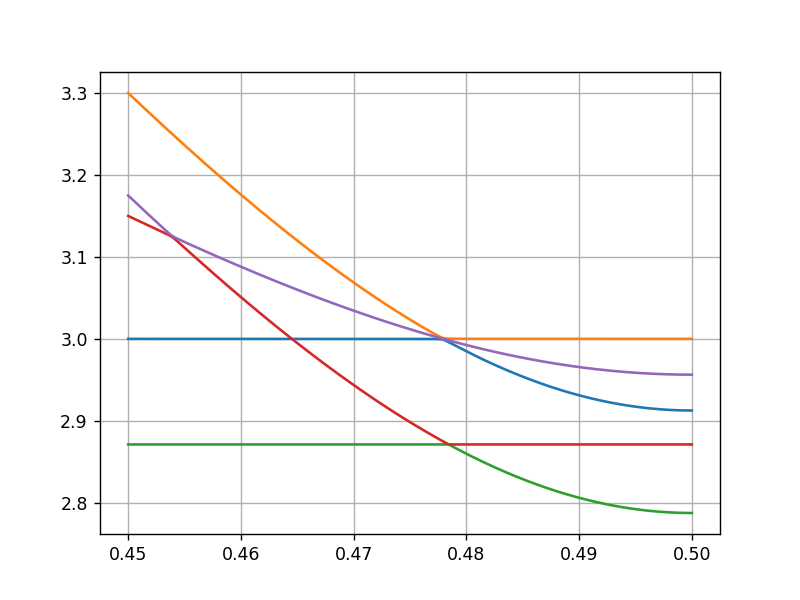

Energy levels calculation:   0%|          | 0/500 [00:00<?, ?it/s]

In [4]:
phi1s = linspace(0.45,0.5,500)
phi2s = ones_like(phi1s)*1/2
figure()
dts.plot_spectrum(phi1s, phi2s, exact_H = False)

In [5]:
#figure()
phi1s = linspace (0.0, 0.55, 400)
phi2s = ones_like(phi1s)*1/2
freq10=[]
freq01=[]
freq11=[]
freq02=[]
freq20=[]

for ind in tqdm(range(len(phi1s))):
    phi1 = phi1s[ind]
    phi2 = phi2s[ind]
    freq10.append((dts.e_state(phi1,phi2,1,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/pi)
    freq01.append((dts.e_state(phi1,phi2,2,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/pi)
    freq11.append((dts.ee_state(phi1,phi2,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/2/pi)
    freq20.append((dts.f_state(phi1,phi2,1,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/2/pi)
    freq02.append((dts.f_state(phi1,phi2,2,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/2/pi)


/tmp/ipykernel_2245845/1032510388.py:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phi1s = linspace (0.0, 0.55, 400)
/tmp/ipykernel_2245845/1032510388.py:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  phi2s = ones_like(phi1s)*1/2
  0%|                                                                                           | 0/400 [00:00<?, ?it/s]/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 24.83it/s]


## System spectrum


In [163]:
phi1s = linspace (0.40, 0.55, 400)
phi2s = ones_like(phi1s)*1/2
nu01, nu02, nu10, nu11 = [], [], [], []

for  ind, phi in enumerate (phi1s):
    H1 = tr1.H_diag_trunc_approx(phi)
    H2 = tr2.H_diag_trunc_approx(phi2s[ind])
    evals,evecs = H1.eigenstates()
    evals2,evecs2 = H2.eigenstates()
    nu01.append((evals[1]-evals[0])/2/pi)
    nu02.append((evals[2]-evals[0])/2/pi/2)
    nu10.append((evals2[1]-evals2[0])/2/pi)
    nu11.append((evals2[1]-evals2[0]+evals[1]-evals[0])/2/pi/2)
    
    

    


/tmp/ipykernel_2201824/764663624.py:1: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phi1s = linspace (0.40, 0.55, 400)
/tmp/ipykernel_2201824/764663624.py:2: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  phi2s = ones_like(phi1s)*1/2


<IPython.core.display.Javascript object>


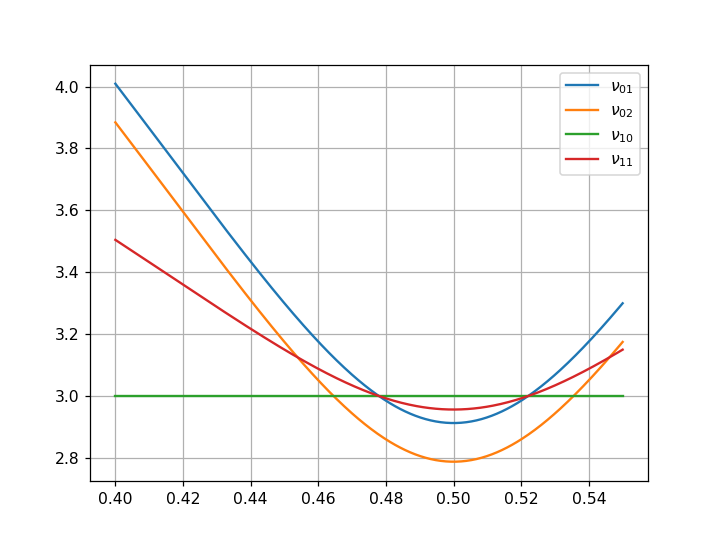

In [164]:
figure()
plot (phi1s, nu01, label = '$\\nu_{01}$' )
plot (phi1s, nu02, label = '$\\nu_{02}$' )
plot (phi1s, nu10, label = '$\\nu_{10}$' )
plot (phi1s, nu11, label = '$\\nu_{11}$' )
legend()
grid()    

## CPhase gate

In [4]:
signal = ZPulse(Ts,params)
waveform1 = signal.waveform_cphase(200, 550) 
waveform2 = 0.5*ones_like(waveform1)
#waveform2 = signal.waveform_iswap_zgate(2, t_start = 200, t_finish = 247, t_zgate = 9.2)

/tmp/ipykernel_2453562/532870116.py:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  waveform2 = 0.5*ones_like(waveform1)


<IPython.core.display.Javascript object>


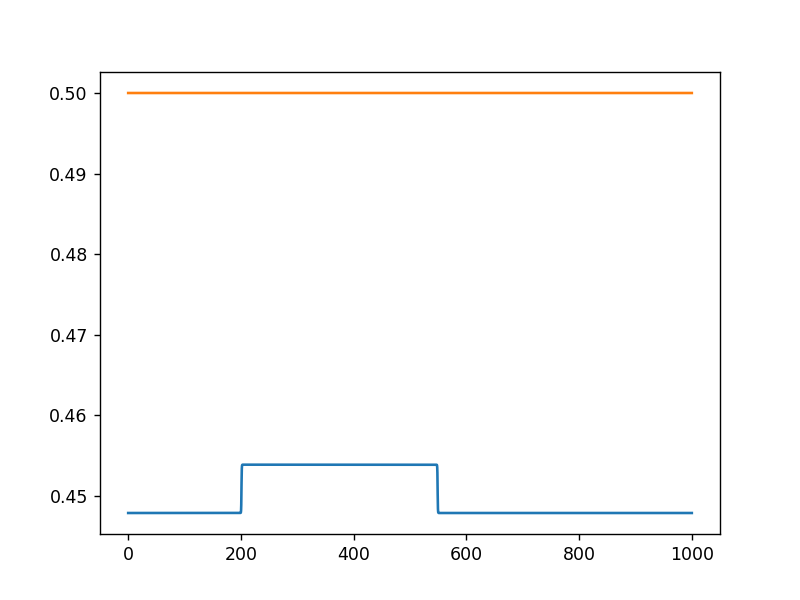

In [5]:
figure()
plot (Ts, waveform1)
plot (Ts, waveform2)

## $|1\rangle\ |+i\rangle\ \rightarrow|1\rangle\ |-i\rangle$

In [6]:
T._2q_rotations[7]


((167.25, 0), (167.25, 0))

In [7]:
rho0 = Qobj(ket2dm(basis(9,0)), dims = [[3,3],[3,3]])
H_class = dts.H_iswap_RF_RWA_td(waveform1, waveform2, params, rotations = T._2q_rotations[10])
ops = [dts.two_qubit_operator(qubit1_operator = tr1.sx()),dts.two_qubit_operator(qubit1_operator = tr1.sy()),\
    dts.two_qubit_operator(qubit1_operator = tr1.sz()), dts.two_qubit_operator(qubit2_operator = tr2.sx()),\
    dts.two_qubit_operator(qubit2_operator = tr2.sy()),dts.two_qubit_operator(qubit2_operator = tr2.sz())]
result = mesolve(H_class , rho0, Ts, c_ops = [],e_ops = dts.e_ops,progress_bar=True,
                 options=Options(nsteps = 200000, max_step =1e-2, store_states = True))

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   0.62s. Est. time left: 00:00:00:05
20.0%. Run time:   1.45s. Est. time left: 00:00:00:05
30.0%. Run time:   1.99s. Est. time left: 00:00:00:04
40.0%. Run time:   2.46s. Est. time left: 00:00:00:03
50.0%. Run time:   2.96s. Est. time left: 00:00:00:02
60.0%. Run time:   3.46s. Est. time left: 00:00:00:02
70.0%. Run time:   3.95s. Est. time left: 00:00:00:01
80.0%. Run time:   4.45s. Est. time left: 00:00:00:01
90.0%. Run time:   4.96s. Est. time left: 00:00:00:00
Total run time:   5.44s


<IPython.core.display.Javascript object>


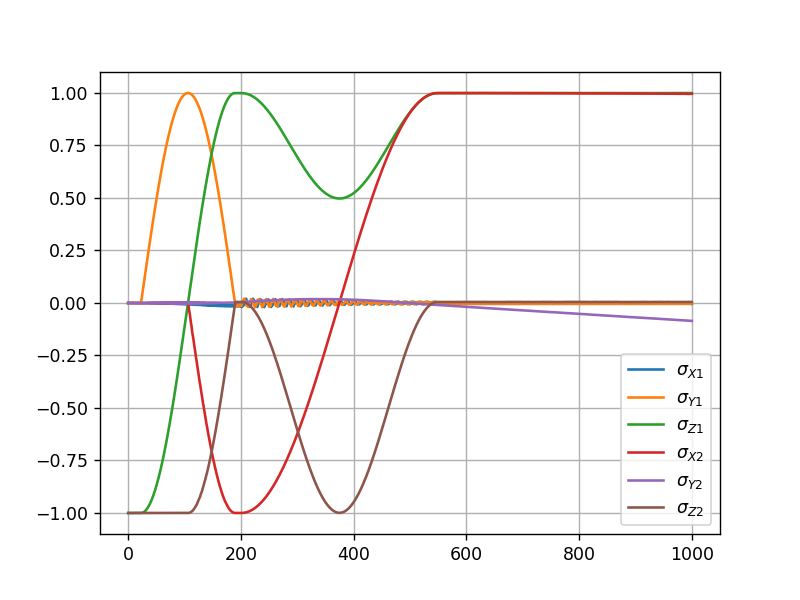

In [8]:
figure()
plot (Ts, result.expect[0], label = '$\sigma_{X1}$')
plot (Ts, result.expect[1], label = '$\sigma_{Y1}$')
plot (Ts, result.expect[2], label = '$\sigma_{Z1}$')
plot (Ts, result.expect[3],label = '$\sigma_{X2}$')
plot (Ts, result.expect[4], label = '$\sigma_{Y2}$')
plot (Ts, result.expect[5], label = '$\sigma_{Z2}$')
grid()
legend()

## $|1\rangle\ |+\rangle\ \rightarrow|1\rangle\ |-\rangle$

In [9]:
print(T._2q_rotations[11])
rho0 = Qobj(ket2dm(basis(9,0)), dims = [[3,3],[3,3]])
H_class = dts.H_iswap_RF_RWA_td(waveform1, waveform2, params, rotations = T._2q_rotations[11])
ops = [dts.two_qubit_operator(qubit1_operator = tr1.sx()),dts.two_qubit_operator(qubit1_operator = tr1.sy()),\
    dts.two_qubit_operator(qubit1_operator = tr1.sz()), dts.two_qubit_operator(qubit2_operator = tr2.sx()),\
    dts.two_qubit_operator(qubit2_operator = tr2.sy()),dts.two_qubit_operator(qubit2_operator = tr2.sz())]
result = mesolve(H_class , rho0, Ts, c_ops = [],e_ops = dts.e_ops,progress_bar=True,
                 options=Options(nsteps = 200000, max_step =1e-2, store_states = True))

((167.25, 0), (83.625, -1.5707963267948966))


/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   0.65s. Est. time left: 00:00:00:05
20.0%. Run time:   1.15s. Est. time left: 00:00:00:04
30.0%. Run time:   1.70s. Est. time left: 00:00:00:03
40.0%. Run time:   2.40s. Est. time left: 00:00:00:03
50.0%. Run time:   3.08s. Est. time left: 00:00:00:03
60.0%. Run time:   3.73s. Est. time left: 00:00:00:02
70.0%. Run time:   4.34s. Est. time left: 00:00:00:01
80.0%. Run time:   4.84s. Est. time left: 00:00:00:01
90.0%. Run time:   5.39s. Est. time left: 00:00:00:00
Total run time:   5.95s


<IPython.core.display.Javascript object>


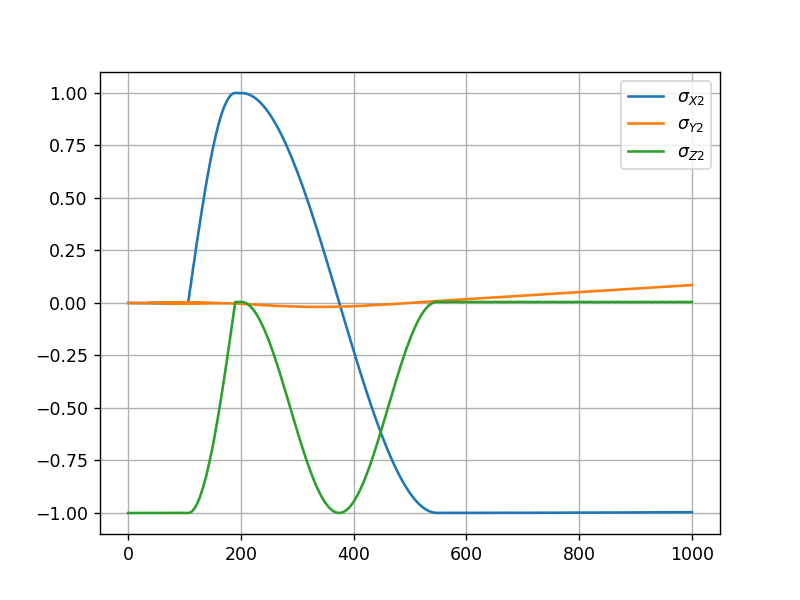

In [10]:
figure()
#plot (Ts, result.expect[0], label = '$\sigma_{X1}$')
#plot (Ts, result.expect[1], label = '$\sigma_{Y1}$')
#plot (Ts, result.expect[2], label = '$\sigma_{Z1}$')
plot (Ts, result.expect[3],label = '$\sigma_{X2}$')
plot (Ts, result.expect[4], label = '$\sigma_{Y2}$')
plot (Ts, result.expect[5], label = '$\sigma_{Z2}$')
grid()
legend()

In [11]:
rho0 = Qobj(ket2dm(basis(9,0)), dims = [[3,3],[3,3]])
H_class = dts.H_iswap_RF_RWA_td(waveform1, waveform2, params, rotations = T._2q_rotations[16])
ops = [dts.two_qubit_operator(qubit1_operator = tr1.sx()),dts.two_qubit_operator(qubit1_operator = tr1.sy()),\
    dts.two_qubit_operator(qubit1_operator = tr1.sz()), dts.two_qubit_operator(qubit2_operator = tr2.sx()),\
    dts.two_qubit_operator(qubit2_operator = tr2.sy()),dts.two_qubit_operator(qubit2_operator = tr2.sz())]
result = mesolve(H_class , rho0, Ts, c_ops = [],e_ops = dts.e_ops,progress_bar=True,
                 options=Options(nsteps = 200000, max_step =1e-2, store_states = True))

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   0.58s. Est. time left: 00:00:00:05
20.0%. Run time:   1.06s. Est. time left: 00:00:00:04
30.0%. Run time:   1.60s. Est. time left: 00:00:00:03
40.0%. Run time:   2.24s. Est. time left: 00:00:00:03
50.0%. Run time:   2.76s. Est. time left: 00:00:00:02
60.0%. Run time:   3.26s. Est. time left: 00:00:00:02
70.0%. Run time:   3.78s. Est. time left: 00:00:00:01
80.0%. Run time:   4.60s. Est. time left: 00:00:00:01
90.0%. Run time:   5.25s. Est. time left: 00:00:00:00
Total run time:   5.84s


<IPython.core.display.Javascript object>


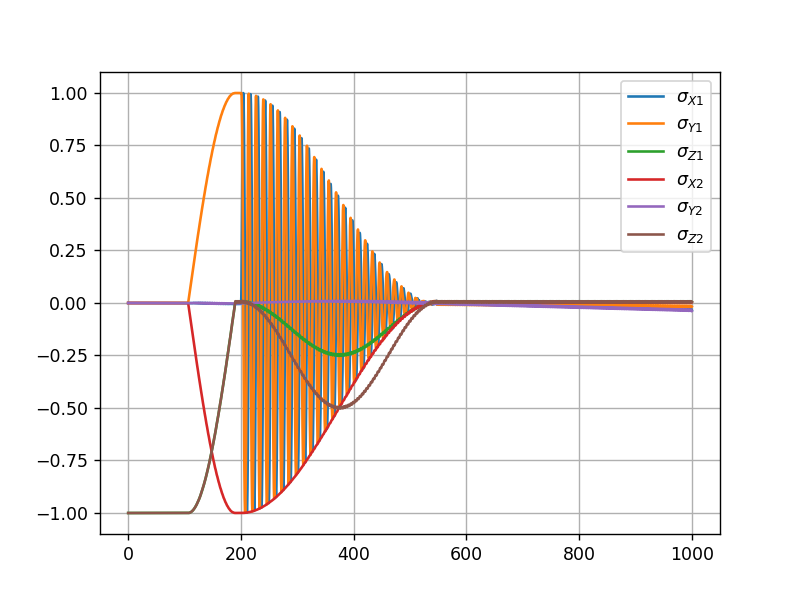

In [12]:
figure()
plot (Ts, result.expect[0], label = '$\sigma_{X1}$')
plot (Ts, result.expect[1], label = '$\sigma_{Y1}$')
plot (Ts, result.expect[2], label = '$\sigma_{Z1}$')
plot (Ts, result.expect[3],label = '$\sigma_{X2}$')
plot (Ts, result.expect[4], label = '$\sigma_{Y2}$')
plot (Ts, result.expect[5], label = '$\sigma_{Z2}$')
grid()
legend()

## Form of the pulse

<IPython.core.display.Javascript object>


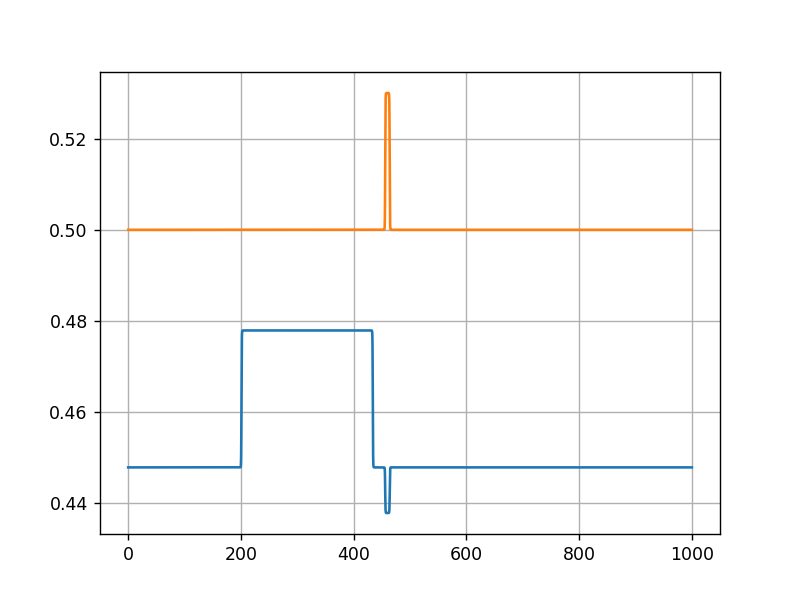

In [13]:
signal = ZPulse(Ts,params)
waveform1 = signal.waveform_iswap_zgate(1)#, t_start = 200 , t_finish = 247, t_zgate = 13.46)
#waveform1 = ones_like(Ts)*params['phi_base_level']
waveform2 = signal.waveform_iswap_zgate(2)#, t_start = 200, t_finish = 247, t_zgate = 13.2)
figure()
plot (Ts, waveform1)
plot (Ts, waveform2)

grid()

## Time evolution

In [171]:
T._2q_rotations[8]

((167.25, 0), (83.625, 0))

In [172]:
rho0 = Qobj(ket2dm(basis(9,0)), dims = [[3,3],[3,3]])

In [173]:
H_class = dts.H_iswap_RF_RWA_td(waveform1, waveform2, params, rotations = T._2q_rotations[8])

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [174]:
ops = [dts.two_qubit_operator(qubit1_operator = tr1.sx()),dts.two_qubit_operator(qubit1_operator = tr1.sy()),\
    dts.two_qubit_operator(qubit1_operator = tr1.sz()), dts.two_qubit_operator(qubit2_operator = tr2.sx()),\
    dts.two_qubit_operator(qubit2_operator = tr2.sy()),dts.two_qubit_operator(qubit2_operator = tr2.sz())]

In [175]:
result = mesolve(H_class , rho0, Ts, c_ops = [],e_ops = dts.e_ops,progress_bar=True,
                 options=Options(nsteps = 200000, max_step =1e-2, store_states = True))

10.0%. Run time:   0.27s. Est. time left: 00:00:00:02
20.0%. Run time:   0.56s. Est. time left: 00:00:00:02
30.0%. Run time:   0.83s. Est. time left: 00:00:00:01
40.0%. Run time:   1.11s. Est. time left: 00:00:00:01
50.0%. Run time:   1.38s. Est. time left: 00:00:00:01
60.0%. Run time:   1.65s. Est. time left: 00:00:00:01
70.0%. Run time:   1.92s. Est. time left: 00:00:00:00
80.0%. Run time:   2.32s. Est. time left: 00:00:00:00
90.0%. Run time:   2.60s. Est. time left: 00:00:00:00
Total run time:   2.88s


In [176]:
#rho_final = Tomography.rho3dim_to_rho(result.states[-1])

In [19]:
rho_final, rho_ideal = T.find_cphase_rotation_matrix(23,pi)
state_fidelity = Tomography.state_fidelity(rho_final, rho_ideal)
print(state_fidelity)

(0.9979770873072934+1.8061302895475624e-08j)


In [177]:
rho_final, rho_ideal = T.find_iswap_rotation_matrix(8)
state_fidelity = Tomography.state_fidelity(rho_final, rho_ideal)
print(state_fidelity)

(0.991595876654693+1.7099519962653437e-08j)


<IPython.core.display.Javascript object>


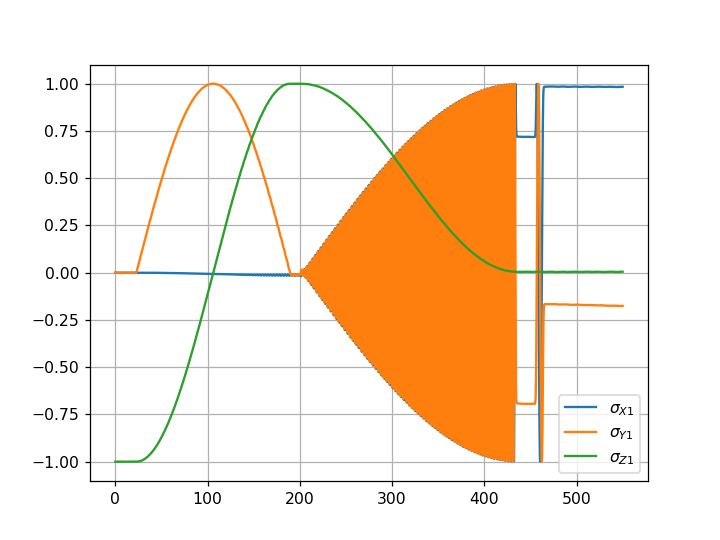

In [178]:
figure()
plot (Ts, result.expect[0], label = '$\sigma_{X1}$')
plot (Ts, result.expect[1], label = '$\sigma_{Y1}$')
plot (Ts, result.expect[2], label = '$\sigma_{Z1}$')
grid()
legend()

<IPython.core.display.Javascript object>


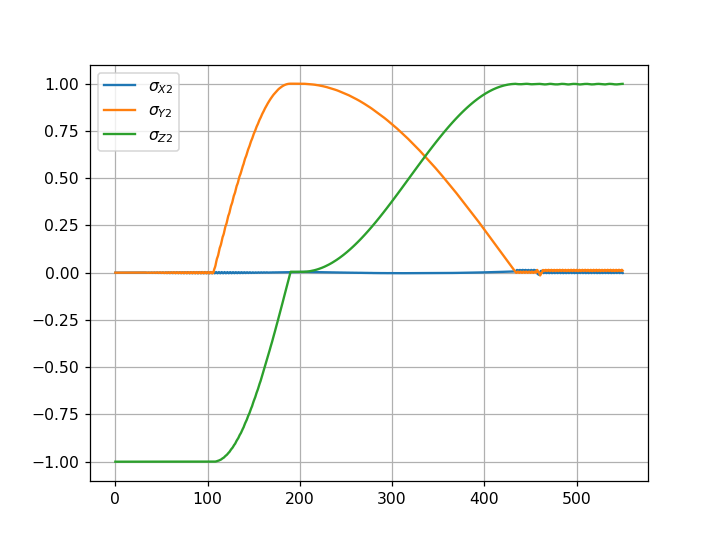

In [179]:
figure()
plot (Ts, result.expect[3],label = '$\sigma_{X2}$')
plot (Ts, result.expect[4], label = '$\sigma_{Y2}$')
plot (Ts, result.expect[5], label = '$\sigma_{Z2}$')
grid()
legend()

<IPython.core.display.Javascript object>


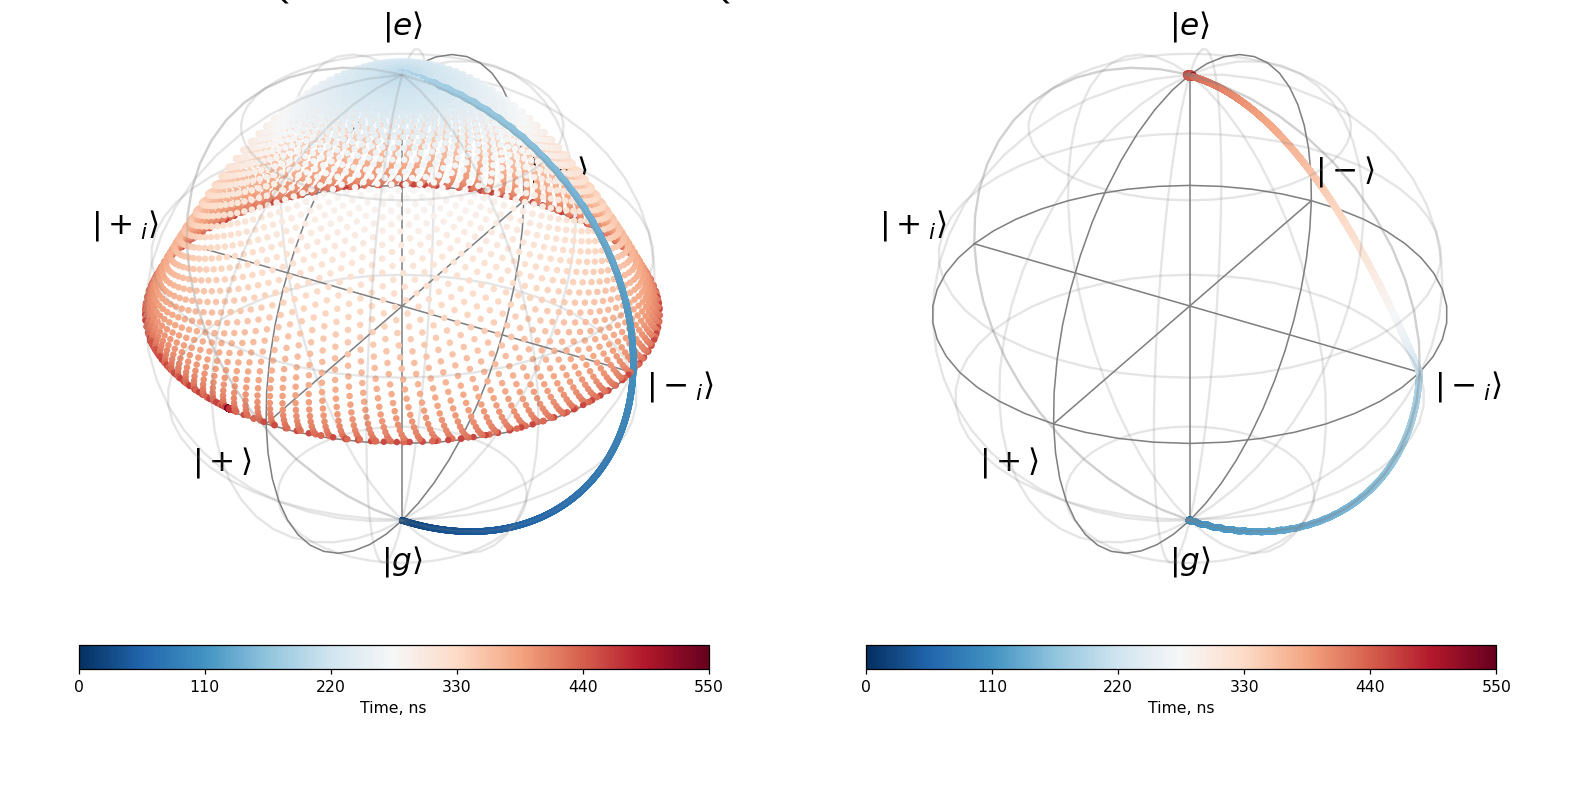

<IPython.core.display.Javascript object>


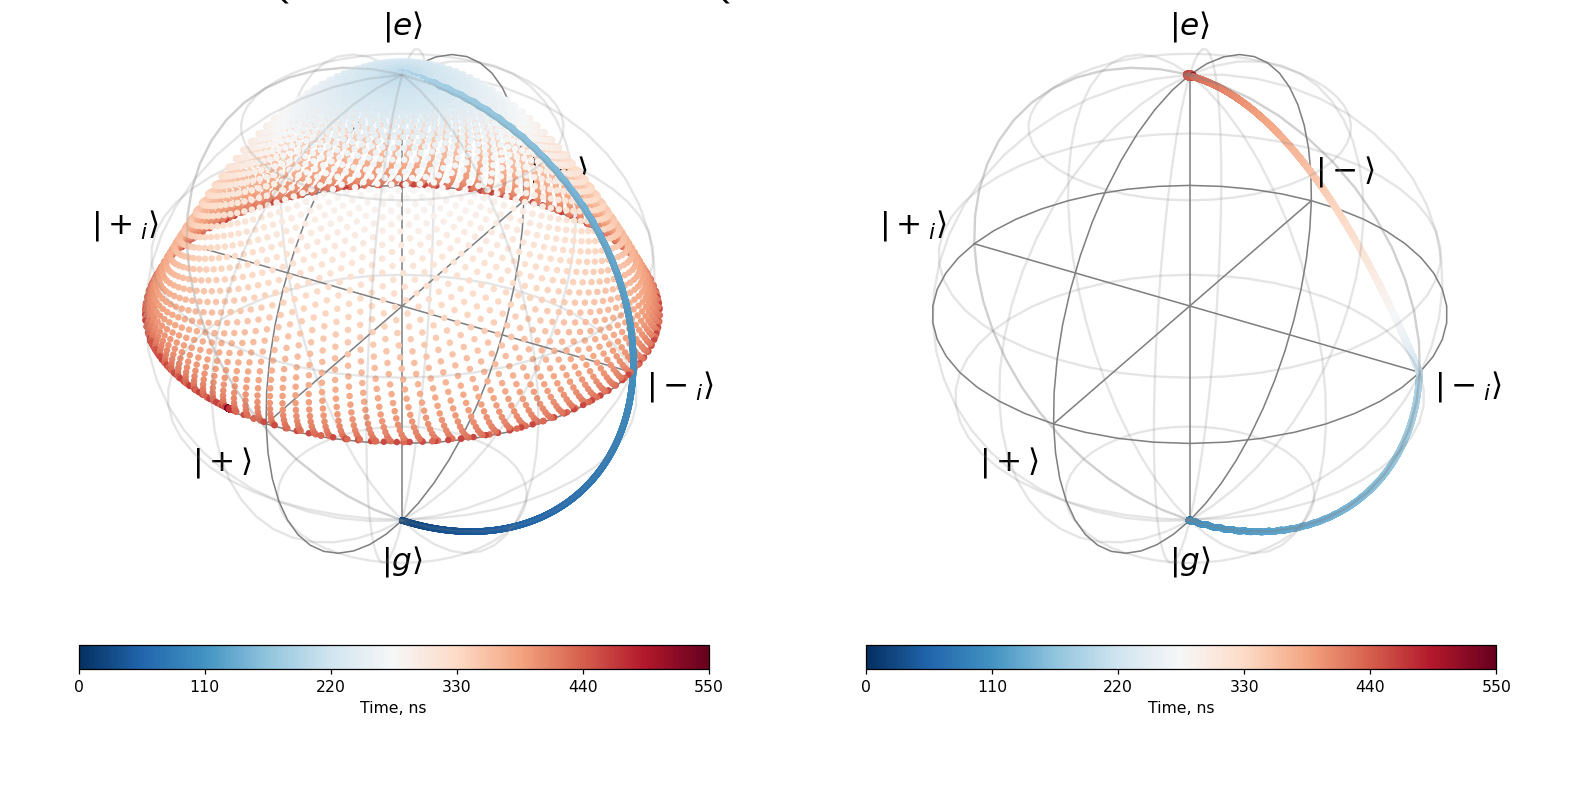

In [180]:
T.plot_qubits_dynamic(10,dm=result.states, interaction = True)

## Gate calibration

## $|0\rangle\ |-\rangle\ \rightarrow|-i\rangle\ |0\rangle$

In [181]:
signal = ZPulse(Ts,params)
rho0 = Qobj(ket2dm(basis(9,0)), dims = [[3,3],[3,3]])
waveform1 = signal.waveform_iswap_zgate(1, t_start = 200 , t_finish = 247, t_zgate = 31)
#waveform1 = ones_like(Ts)*params['phi_base_level']
waveform2 = signal.waveform_iswap_zgate(2, t_start = 200, t_finish = 247, t_zgate = 31)
H_class = dts.H_iswap_RF_RWA_td(waveform1, waveform2, params, rotations =  ((0, 0),(33.45*5/2,pi/2)))
result = mesolve(H_class , rho0, Ts, c_ops = [],e_ops = dts.e_ops,progress_bar=True,
                 options=Options(nsteps = 200000, max_step =1e-3, store_states = True))



/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   2.14s. Est. time left: 00:00:00:19
20.0%. Run time:   4.28s. Est. time left: 00:00:00:17
30.0%. Run time:   6.60s. Est. time left: 00:00:00:15
40.0%. Run time:   8.85s. Est. time left: 00:00:00:13
50.0%. Run time:  11.03s. Est. time left: 00:00:00:11
60.0%. Run time:  13.21s. Est. time left: 00:00:00:08
70.0%. Run time:  15.40s. Est. time left: 00:00:00:06
80.0%. Run time:  17.60s. Est. time left: 00:00:00:04
90.0%. Run time:  19.80s. Est. time left: 00:00:00:02
Total run time:  22.05s


In [182]:
T.fidelity_function_zgate(10,10,params['start'],4)

TypeError: fidelity_function_zgate() takes 4 positional arguments but 5 were given